In [16]:
from datasets import load_dataset
from utils import jpeg_compress, webp_compress, pad, crop, nn_compress, hific_lo_compress
import compressai
from evaluate import evaluator
from transformers import pipeline
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def jpeg_compress_in(sample):
    img,bpp = jpeg_compress(sample['image'])
    sample['image'] = img
    sample['bpp' ] = bpp
    return sample
    
def webp_compress_in(sample):
    img,bpp = webp_compress(sample['image'])
    sample['image'] = img
    sample['bpp' ] = bpp
    return sample

device = "cuda"
net_mbt2018 = compressai.zoo.mbt2018(quality=1, pretrained=True).eval().to(device)
def mbt2018_compress_in(sample):
    img,bpp = nn_compress(sample['image'],net_mbt2018,device)
    sample['image'] = img
    sample['bpp'] = bpp
    return sample

def hific_lo_compress_in(sample):
    img,bpp = hific_lo_compress(sample['image'])
    sample['image'] = img
    sample['bpp' ] = bpp
    return sample

In [3]:
image_compression_methods = [
    jpeg_compress_in,
    webp_compress_in,
    mbt2018_compress_in,
    hific_lo_compress_in
]
models = [
    "microsoft/resnet-18",
    "google/vit-base-patch16-224",
    "microsoft/beit-large-patch16-224"
]

In [4]:
imagenet = [load_dataset("imagenet-1k", split="validation[:100]")]

In [5]:
for method in image_compression_methods:
    imagenet.append(imagenet[0].map(method))

In [6]:
pipe = []
for model in models:
    pipe.append(
        pipeline(
            task="image-classification",
            model=model,
            device="cuda:0"
        )
    )

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [7]:
task_evaluator = evaluator("image-classification")

In [8]:
eval_results = []
for i_method,method in enumerate(imagenet):
    eval_results.append([])
    for i_model,model in enumerate(pipe):
        eval_results[i_method].append(
            task_evaluator.compute(
                model_or_pipeline=model,
                data=method,
                metric="accuracy",
                label_mapping=model.model.config.label2id
            )
        )

In [55]:
classification_acc = np.array(
    [[rij['accuracy'] for rij in r] for r in eval_results]
)
classification_acc

array([[0.7 , 0.84, 0.86],
       [0.39, 0.62, 0.8 ],
       [0.54, 0.77, 0.84],
       [0.55, 0.68, 0.74],
       [0.74, 0.81, 0.84]])

In [56]:
baseline_acc = classification_acc[0,1]
classification_acc = classification_acc[1:,1]

In [46]:
image_bpp = [np.mean(method['bpp']) for method in imagenet[1:]]
image_bpp

[0.2592755356771014,
 0.14186963777366465,
 0.14166572336543287,
 0.025749066368513544]

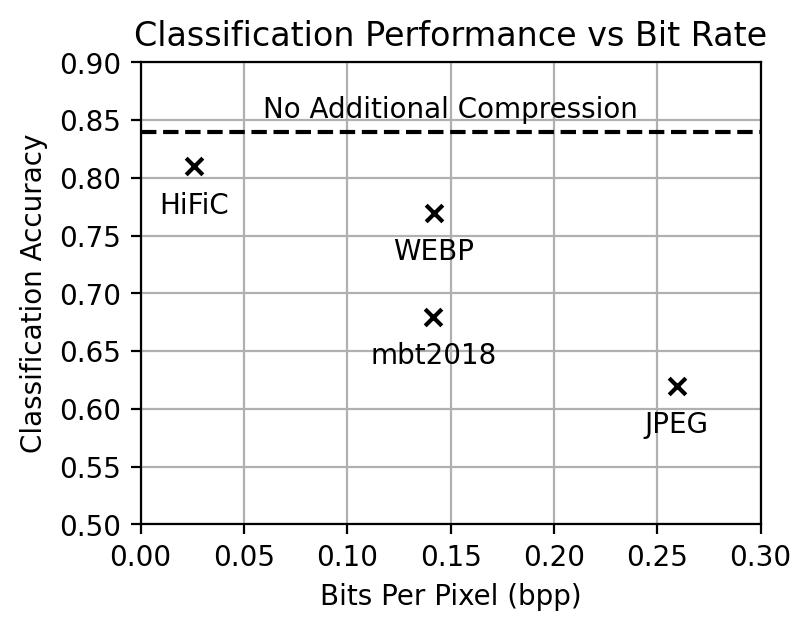

In [73]:
image_compression_names = [
    'JPEG',
    'WEBP',
    'mbt2018',
    'HiFiC'
]
plt.figure(figsize=(4, 3),dpi=200)
plt.scatter(image_bpp, classification_acc, c='black', marker='x')
plt.annotate("No Additional Compression", (0.15, baseline_acc), textcoords="offset points", xytext=(0,5), ha='center')
plt.plot([0,1],[baseline_acc,baseline_acc],'--',c='black')
for i, name in enumerate(image_compression_names):
    plt.annotate(name, (image_bpp[i], classification_acc[i]), textcoords="offset points", xytext=(0,-17), ha='center')
plt.xlabel('Bits Per Pixel (bpp)')
plt.ylabel('Classification Accuracy')
plt.title('Classification Performance vs Bit Rate')
plt.xlim([0,0.3])
plt.ylim([0.5,0.9])
plt.grid(True)
plt.show()